In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### load dataset from directory

In [18]:
batch_size = 32
IMG_SIZE = (240, 240)

train_dir = 'data/images/cls_2/train'

#train_dir = 'data/images_balanced/train'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=None,
  shuffle = False,
  image_size=IMG_SIZE,
  batch_size=None)

img, lbl = tuple(zip(*train_ds))

file_paths = train_ds.file_paths
y_patient = ['_'.join(x.split('/')[-1].split('_')[0:2]) for x in file_paths] # -> 0_f1
file_tensor = tf.convert_to_tensor(y_patient)

indices = tf.range(start=0, limit=tf.shape(lbl)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed = 8)

shuffled_x = tf.gather(img, shuffled_indices)
shuffled_y = tf.gather(lbl, shuffled_indices)
shuffled_file = tf.gather(y_patient, shuffled_indices)

val_size = int(tf.shape(lbl)[0].numpy() * 0.2)
print(val_size)
ds_all = tf.data.Dataset.from_tensor_slices((shuffled_x,shuffled_y))
ds_val = ds_all.take(val_size).batch(32)
ds_train = ds_all.skip(val_size).batch(32)

val_files = shuffled_file[:val_size]

Found 3343 files belonging to 2 classes.
668


### Image Preview

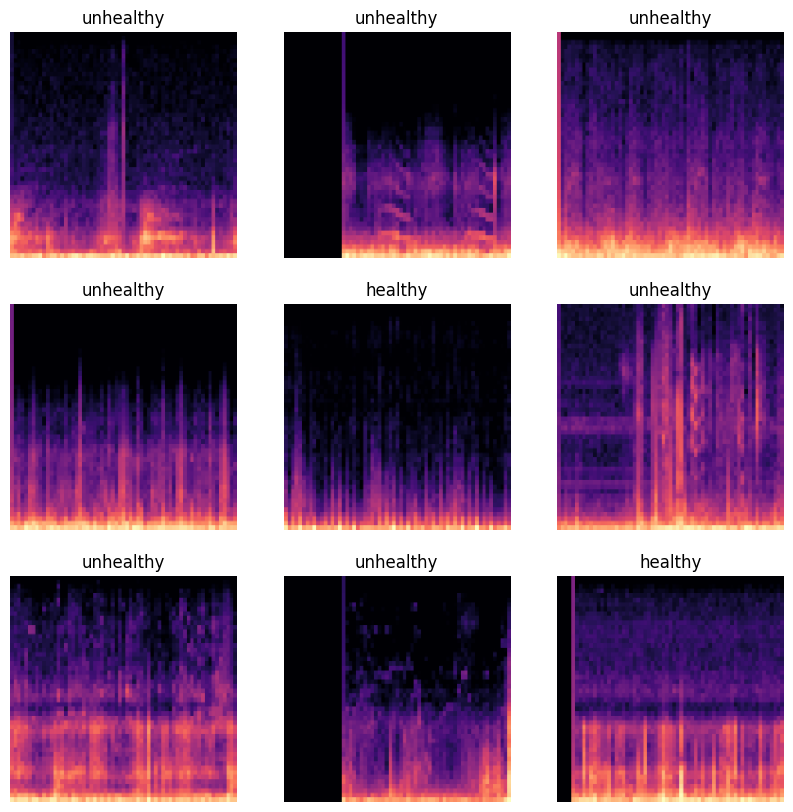

In [19]:
class_names = ['unhealthy', 'healthy']

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

In [20]:
AUTOTUNE = tf.data.AUTOTUNE #find a good allocation of CPU budget automatically

#use buffered prefetching, to yield data from disk without having I/O become blocking
train_ds = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = ds_val.cache().prefetch(buffer_size=AUTOTUNE)


### Data Augmentation

In [21]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### Rescale pixel values

In [22]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model from the pre-trained ResNet50

In [23]:
# Create the base model from the pre-trained model ResNet50V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Freeze the convolutional base

In [24]:
base_model.trainable = False

### Basemodel summary

In [25]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 120, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Add a classification head

In [26]:
# converts the features (output of base model) to a single 2048-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Add Dense Layer

In [27]:
#No activation Function needed because positive numbers predict class 1, negative numbers predict class 0
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

### Build a model

In [28]:
inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [29]:
#Compile the model before training it. Since there are two classes,
#use tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

### Train the model

In [31]:
loss0, accuracy0 = model.evaluate(val_ds)

2022-11-15 14:41:13.754442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 5s 146ms/step - loss: 0.8637 - accuracy: 0.2515


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
initial_epochs = 50

initial loss: 0.86
initial accuracy: 0.25


In [33]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/50


2022-11-15 14:41:26.256227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 21s 224ms/step - loss: 0.7130 - accuracy: 0.6318 - val_loss: 0.3645 - val_accuracy: 0.8997
Epoch 2/50
84/84 [==============================] - 18s 214ms/step - loss: 0.4206 - accuracy: 0.8628 - val_loss: 0.3313 - val_accuracy: 0.8997
Epoch 3/50
84/84 [==============================] - 18s 211ms/step - loss: 0.3849 - accuracy: 0.8650 - val_loss: 0.3195 - val_accuracy: 0.8997
Epoch 4/50
84/84 [==============================] - 18s 214ms/step - loss: 0.3588 - accuracy: 0.8647 - val_loss: 0.3113 - val_accuracy: 0.8997
Epoch 5/50
84/84 [==============================] - 18s 214ms/step - loss: 0.3475 - accuracy: 0.8669 - val_loss: 0.3049 - val_accuracy: 0.8997
Epoch 6/50
84/84 [==============================] - 18s 213ms/step - loss: 0.3346 - accuracy: 0.8677 - val_loss: 0.2993 - val_accuracy: 0.8997
Epoch 7/50
84/84 [==============================] - 18s 212ms/step - loss: 0.3276 - accuracy: 0.8725 - val_loss: 0.2950 - val_accuracy: 0.8997
Epoch 8/50

### Learning Curves

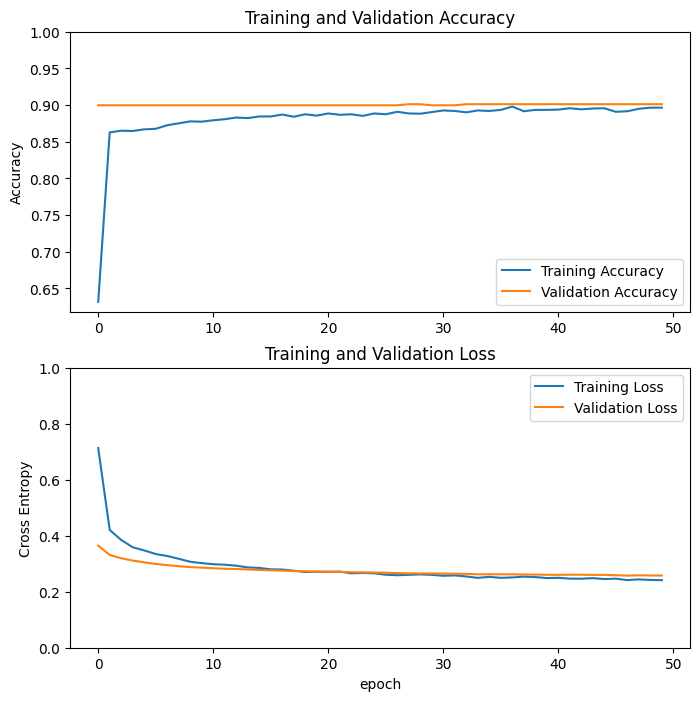

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Note: If you are wondering why the validation metrics are clearly better than the training metrics,
#the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout
#affect accuracy during training. They are turned off when calculating validation loss.

In [35]:
y_pred = model.predict(val_ds)

2022-11-15 14:59:17.947368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [36]:
for x,y in val_ds.as_numpy_iterator():
    print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
[0 0 0 0 0

In [37]:
y = np.concatenate([y for x, y in val_ds], axis=0)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [38]:

y_pred = model.predict(val_ds)
y_pred = y_pred.squeeze(-1)
y_pred.shape

(668,)

In [39]:
len(val_files)
names = val_files.numpy()

In [40]:

df = pd.DataFrame([names, y, y_pred], index = ['filename', 'y', 'y_pred']).T
df_patient = df.groupby('filename').mean()
df_patient['y_pred_hard'] = df_patient['y_pred'].round()
df_patient

,y,y_pred,y_pred_hard
filename,,,
b'0_f1',0.0,0.103375,0.0
b'0_f101',0.0,0.078096,0.0
b'0_f104',0.0,0.117564,0.0
b'0_f105',0.0,0.220164,0.0
b'0_f106',0.0,0.102321,0.0
...,...,...,...
b'1_i159',1.0,0.027617,0.0
b'1_i179',1.0,0.163500,0.0
b'1_i183',1.0,0.058023,0.0


In [41]:
confusion_matrix(df_patient.y, df_patient.y_pred_hard)

array([[120,   0],
       [ 35,   0]])

In [42]:
print(classification_report(df_patient.y, df_patient.y_pred_hard))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       120
         1.0       0.00      0.00      0.00        35

    accuracy                           0.77       155
   macro avg       0.39      0.50      0.44       155
weighted avg       0.60      0.77      0.68       155



/Users/louiskrause/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/louiskrause/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/louiskrause/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

### Fine tuning

Read before you go on:

This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

In [35]:
import random
import os
random.seed(42)
random.sample(range(49),1)
list = ['1','2','3']
path = '../..'
os.listdir()


['.DS_Store',
 'LICENSE',
 'requirements.txt',
 'ResNet50_Transfer_Learning.ipynb',
 'Makefile',
 '__init__.py',
 'models',
 'JNotebooks',
 'Client_side_app',
 'README.md',
 '.gitignore',
 '.venv',
 'scripts',
 '.python-version',
 '.ipynb_checkpoints',
 '.git',
 'data']